In [15]:
import numpy as np
from scipy import stats
import itertools
import matplotlib.pyplot as plt
from Landscapes import *
import pandas as pd
from scipy.interpolate import UnivariateSpline
import numpy


# Define key functions to get landscape statistics and local maxima statistics

In [2]:
def Get_Landscape_Statistics_Outputs(df,N,K,mycolor="b"):


    ##Record the autocorrelation of a random walk
    FitnessPath = random_walker(1000, df)
    AR = Get_AR(FitnessPath,lag_range=N)


    ##Now find the maximum and minimum.
    MaximalLocation = df.iloc[:,0].idxmax()    #get the index
    MaximalFitness = df.iloc[:,0].max() #get the fitness value
    #MaximalFitness2 = df[MaximalLocation,0]
    #,MaximalFitness2)
    MinimalLocation = df.iloc[:,0].idxmin()
    MinimalFitness = df.iloc[:,0].min()

    #Get normalized difference between min and max (by dividing by standard deviation)
    NormDiff = (MaximalFitness-MinimalFitness)/(df.iloc[:,0].var()**0.5)

    #get distance between min and max
    Changes = sum(abs(np.array(df.loc[MinimalLocation].Location)-np.array(df.loc[MaximalLocation].Location)))

    ####Now generate a statistic that finds how close on average, are the 90th percentile and above
    ####fitness to the maximum.
    
    
    
    
    Percentile_90_Cutoff = (df.iloc[:,0].quantile(.90))
    
    #get those that pass cutoff
    
    CutoffPassed = df[ df.iloc[:,0]>= Percentile_90_Cutoff]
    
    Distances = CutoffPassed['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    
    Average_Distance_Percentile_90=Distances.mean()

    ##Now Identify the Number of Maxima
    Number_Maxima = Count_Local_Maxima(df)
    return(Number_Maxima,Average_Distance_Percentile_90,Changes,NormDiff,AR[1],AR[2],AR[3])

    plt.figure(figsize=(10,4))
    plt.title("Auto-correlation by step distance, N={} K={}".format(N,K),size=24)
    plt.grid()
    plt.plot(AR,color=mycolor)
    plt.show()
    print("Max Fitness\t\t\t\t", MaximalFitness)
    print("Min Fitness\t\t\t\t", MinimalFitness)
    print("Normed difference in fitness\t\t", NormDiff)
    print("Distance btw min and max\t\t", Changes)
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    

In [97]:
def Get_Distance_Global_Maximas(df,N,K,mycolor="b"):


    ##Record the autocorrelation of a random walk
    #FitnessPath = random_walker(1000, df)
    #AR = Get_AR(FitnessPath,lag_range=N)


    ##Now find the maximum and minimum.
    MaximalLocation = df.iloc[:,0].idxmax()    #get the index
    MaximalFitness = df.iloc[:,0].max() #get the fitness value
    #MaximalFitness2 = df[MaximalLocation,0]
    #,MaximalFitness2)
    MinimalLocation = df.iloc[:,0].idxmin()
    MinimalFitness = df.iloc[:,0].min()

   
    Current_Maximas_Model = Local_Maxima_Locations(df)
    Current_Maximas_Model = Current_Maximas_Model[Current_Maximas_Model['Maxima']==1]
    Number_Maxima = sum(Current_Maximas_Model['Maxima'])
    Distances_Maximas_to_Global = Current_Maximas_Model['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    Average_Distances_Maximas_to_Global=Distances_Maximas_to_Global.mean()
    Var_Distances_Maximas_to_Global=Distances_Maximas_to_Global.var()
    Max_Distances_Maximas_to_Global=Distances_Maximas_to_Global.max()

        
    return(Number_Maxima,
           Average_Distances_Maximas_to_Global,Var_Distances_Maximas_to_Global,Max_Distances_Maximas_to_Global)

    plt.figure(figsize=(10,4))
    plt.title("Auto-correlation by step distance, N={} K={}".format(N,K),size=24)
    plt.grid()
    plt.plot(AR,color=mycolor)
    plt.show()
    print("Max Fitness\t\t\t\t", MaximalFitness)
    print("Min Fitness\t\t\t\t", MinimalFitness)
    print("Normed difference in fitness\t\t", NormDiff)
    print("Distance btw min and max\t\t", Changes)
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    

In [103]:

def Count_Local_Maxima_Distances(df):
    #Set A Maxima counter
    Num_Local_Max=0
    #Loop over all rows
    Distances =[]
    MaximalLocation = df.iloc[:,0].idxmax() 
    for focal_row in df.itertuples():
        #Identify the Neighbors (distance of 1 from focal row)
        Neighbors = df[df['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(focal_row.Location)))==1)]        #Get the maximum fitness value of the neighbors
        Neighbors_Max = max(Neighbors.Fitness) #fitness is indexed at 0 here for some reason

        ##See if the neighbors max does not exceed the focal max, if not then it is a local maxima
        if Neighbors_Max < focal_row.Fitness: #fitness is indexed at 1 here for some reason
            #print('Local Maxima found')
            Num_Local_Max += 1
            #print(np.array(focal_row))
            #print(np.array(df.loc[MaximalLocation].Location))
            Dist = sum(abs(np.array(focal_row.Location)-np.array(df.loc[MaximalLocation].Location)))
            #don't include global maxima
            if Dist !=0:
            #Dist = np.array(focal_row)-np.array(df.loc[MaximalLocation].Location)
                Distances.append(Dist)
                
        #Append the focal row at the end
    Distances=np.array(Distances)
    if len(Distances)>0:
        return(Num_Local_Max,Distances.mean(),Distances.var(),Distances.max())
    else:
        return(0,0,0,0)



In [3]:
def create_dotSpace(N=10,hypers=[1,1,1,1,1,1,1,1,1,1],masked=False, mask=None):
    our_dirichlet = stats.dirichlet(hypers)    
    all_permutations = list(itertools.product([0,1],repeat = N))
    fitnesses = []
    perms = []
    transformed_locs = []
    for perm in all_permutations:
        fitnesses.append(np.dot(perm,our_dirichlet.rvs()[0]))
        if masked:
            if mask:
                perm = transform(perm,mask)
            else:
                perm = transform(perm)
        perms.append("".join([str(i) for i in perm]))
        transformed_locs.append(perm)
    frame = {"Fitness":pd.Series(fitnesses,index=perms), "Location":pd.Series(transformed_locs,index=perms)}
    return pd.DataFrame(frame)

def transform(location, mask=[1,0,1,0,0,0,1,1,1,0]):
    assert len(location) == len(mask), "The mask needs to be same length as the location"
    
    return [abs(i-1) if j==1 else i for i,j in zip(location, mask)]

def get_iterated_search_walk(Landscape,Neighbor_Distance,Step_Size,Iterations):
    #initalize random position
    N=len(Landscape.iloc[0].Location)
    Position= Position_rand(N)

    FitnessHistory=[Landscape.loc["".join([str(i) for i in Position])].Fitness]
    #record jumps down
    Jump_Down_history=[1]

    for j in range(Iterations):

        #Identify the Neighbors (distance of M from initial position row)
        Neighbors = Landscape[Landscape['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(Landscape.loc["".join([str(i) for i in Position])].Location)))==Neighbor_Distance)]

        BetterNeighbors = Neighbors[Neighbors.Fitness>Landscape.loc["".join([str(i) for i in Position])].Fitness]
        #randomize order of neighobrs then loop until one exceeds
        if len(BetterNeighbors)>0: #only update if there exists at least one superior neighobr
            BetterNeighbors.sample(frac=1)#randomly sample better neighbors
            Position = BetterNeighbors.index.values[0] #return the first index value
            Jump_Down_history.append(0)

        #take a step of size Step_Size
        else:
            Position = Perturbation(Position,Step_Size)
            Jump_Down_history.append(1)

            #Append to fitness data
        fit = Landscape.loc["".join([str(i) for i in Position])].Fitness
        FitnessHistory.append(fit)
        
    return(FitnessHistory,Jump_Down_history)


    
def Get_Landscape_Summary(df,N):


    ##Record the autocorrelation of a random walk
    FitnessPath = random_walker(1000, df)
    AR = Get_AR(FitnessPath,lag_range=N)

    MaximalLocation = df.iloc[:,0].idxmax() #get the index

    ####Now generate a statistic that finds how close on average, are the 90th percentile and above
    ####fitness to the maximum
    Percentile_90_Cutoff = (df.iloc[:,0].quantile(.90))
    #get those that pass cutoff
    CutoffPassed = df[ df.iloc[:,0]>= Percentile_90_Cutoff]
    Distances = CutoffPassed['Location'].apply(lambda row : sum(abs(np.array(row)-np.array(df.loc[MaximalLocation].Location))))
    Average_Distance_Percentile_90=Distances.mean()

    ##Now Identify the Number of Maxima
    Number_Maxima = Count_Local_Maxima(df)

    history, jump_history = get_iterated_search_walk(df,1,2,150)
    
    print("Avg distance for 90th percentile to Max\t", Average_Distance_Percentile_90)
    print("Num of Local Maxima\t\t\t",Number_Maxima)
    
    print("Mean fitness",df.Fitness.mean())
    print("S.D. of fitness", df.Fitness.var()**.5)

    f, axarr = plt.subplots(2,2,figsize=(15,10))
    axarr[0,0].set_title("Auto-correlation by step distance",size=14)
    axarr[0,0].plot(AR,color="b")
    axarr[0,1].set_title("Random Walk",size=14)
    axarr[0,1].plot(FitnessPath[:250])
    axarr[1,0].set_title("Iterated Local Search", size=14)
    axarr[1,0].plot((history),'r--o',label='k=1')
    axarr[1,0].plot((jump_history),'*',label='k=1_Jump')
    axarr[1,0].legend()

    axarr[1,1].set_title("Fitness Distribution", size=14)
    axarr[1,1].hist(df["Fitness"])
    
    plt.show()
    
    cmap=plt.cm.get_cmap('coolwarm')
    landscape_as_graph(df,cmap)

    
def landscape_as_graph(df,cmap):

    N=len(df.iloc[0].name)
    hypercube = nx.hypercube_graph(N)

    colors=[]
    fitness_dict = {}
    f_min = df.iloc[:,0].min()
    f_max = df.iloc[:,0].max()
    fractor = 1/(f_max-f_min)
    for row, focal_row in df.iterrows():
        source_fit = fractor*(focal_row.Fitness - f_min)
        fitness_dict[row]= source_fit
        colors.append(cmap(source_fit))

    nx.set_node_attributes(hypercube,fitness_dict, "fitness")

    nx.draw(hypercube, node_color=colors, with_labels=False, node_size=50,width=.25)  



    

# Run Simulations to get statistics

In [ ]:
#Get landscape statistics for the dot model
N=10
Landscape_stats_dot=[]
for K in range(1,10):
    for i in range(10):
        print(i)
        Hypers =[K,K,K,K,K,K,K,K,K,K]
        current_land = create_dotSpace(N,Hypers)
        Current_Stats = Get_Landscape_Statistics_Outputs(current_land,N,K)
        Landscape_stats_dot.append(Current_Stats)
      #  Get_Landscape_Statistics(landscape,N,K)
#Convert to pandas dataframe and save
DF = pd.DataFrame(Landscape_stats_Kauffman,columns=['Number_Maxima','Average_Distance_Percentile_90','Max-Min_Steps',
                                          'Normalized_MinMax_Fit_Diff',
                                          'Autocorrelation_step_size_1','Autocorrelation_step_size_2','Autocorrelation_step_size_3'])

DF['Type'] = 'Dot'
DF.to_csv('Dot_Model_Maxima_Stats')
    


0
1


In [4]:
#Get landscape statistics for the NK model

N=10
Landscape_stats_Kauffman=[]
for K in range(1,10):
    print(K)
    for i in range(10):
        print(i)
        current_land = make_NK_land(N, K)
        Current_Stats = Get_Landscape_Statistics_Outputs(current_land,N,K)
        Landscape_stats_Kauffman.append(Current_Stats)    

#Convert to pandas dataframe and save
DF = pd.DataFrame(Landscape_stats_Kauffman,columns=['Number_Maxima','Average_Distance_Percentile_90','Max-Min_Steps',
                                          'Normalized_MinMax_Fit_Diff',
                                          'Autocorrelation_step_size_1','Autocorrelation_step_size_2','Autocorrelation_step_size_3'])

DF['Type'] = 'Kauffman'
DF.to_csv('Kauffman_Model_Maxima_Stats')

1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9


In [164]:
#Run simulation to get maxima distance data for the Kauffman NK Model

N=10
Maxima_Dist_stats_Kauffman=[]
for K in range(1,10):
    #print(K)
    for i in range(5):
        print(i)
        current_land = make_NK_land(N, K)
        Current_Stats = Count_Local_Maxima_Distances(current_land)
        Maxima_Dist_stats_Kauffman.append(Current_Stats)
      #  Get_Landscape_Statistics(landscape,N,K)
#Label Columns for maxima distance data for Kauffman mode and save to csv
DFMaxes = pd.DataFrame(Maxima_Dist_stats_Kauffman,columns=['Num_Local_Max','Mean_Distance','Var_Distance','Max_Distance'])

DFMaxes['Type'] = 'Kauffman'
DFMaxes.to_csv('Kauffman_Model_Maxima_Distance_Stats')



1
0
1
2
3
4
2
0
1
2
3
4
3
0
1
2
3
4
4
0
1
2
3
4
5
0
1
2
3
4
6
0
1
2
3
4
7
0
1
2
3
4
8
0
1
2
3
4
9
0
1
2
3
4


In [ ]:
#Run simulation to get maxima distance data for the Dot  Model

N=10
Maxima_Dist_stats_Dot=[]
for K in range(1,10):
    for i in range(10):
        
        Hypers =[K,K,K,K,K,K,K,K,K,K]
        current_land = create_dotSpace(N,Hypers)
                Current_Stats = Count_Local_Maxima_Distances(current_land)
        Maxima_Dist_stats_Dot.append(Current_Stats)
    
#Do some without uniform hyper-parameters
for K in range(1,5):
    for i in range(5):
        
        Hypers =[K,K,K,K+5,K+5,K,K,K,K,K]
        current_land = create_dotSpace(N,Hypers)
        Current_Stats = Count_Local_Maxima_Distances(current_land)
        Maxima_Dist_stats_Dot.append(Current_Stats)



#Label Columns for maxima distance data for Kauffman mode and save to csv
DFMaxesDot = pd.DataFrame(Maxima_Dist_stats_Dot,columns=['Num_Local_Max','Mean_Distance','Var_Distance','Max_Distance'])

DFMaxesDot['Type'] = 'Kauffman'
DFMaxesDot.to_csv('Dot_Model_Maxima_Distance_Stats')



# Analyze Maxima distance Data

In [79]:
#Read in data and combine
DF=pd.read_csv('Kauffman_Model_Maxima_Stats')
DFDot=pd.read_csv('Dot_Model_Maxima_Stats')
DFDot['Type']='Dot'
DFDot=DFDot.drop(['Unnamed: 0'],axis=1)
Df_Combined = DFDot.append(DF)

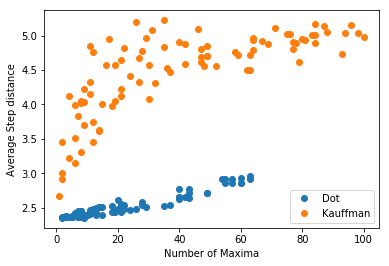

In [80]:
#plot by group
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Average_Distance_Percentile_90"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")

plt.xlabel("Number of Maxima")
plt.ylabel("Average Step distance")
plt.savefig('Steps90pcntile_fitness_Dot_Kauffman.png')

plt.show()

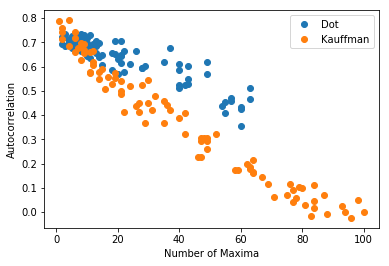

In [83]:
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Autocorrelation_step_size_1"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Autocorrelation")

plt.savefig('AR_1_Dot_Kauffman.png')
plt.show()


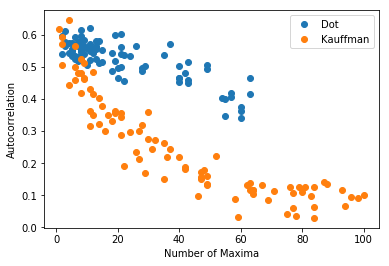

In [84]:
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Autocorrelation_step_size_2"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Autocorrelation")
plt.savefig('AR_2_Dot_Kauffman.png')
plt.show()


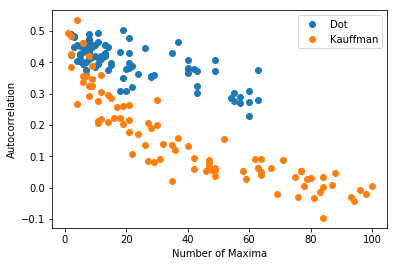

In [85]:
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Autocorrelation_step_size_3"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Autocorrelation")
plt.savefig('AR_3_Dot_Kauffman.png')
plt.show()


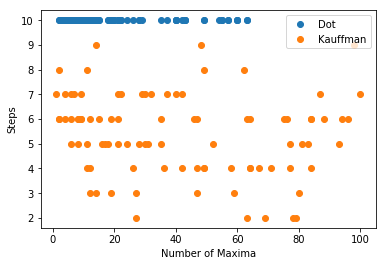

In [86]:
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Max-Min_Steps"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Steps")
plt.savefig('Max-Min_Steps_Dot_Kauffman.png')
plt.show()


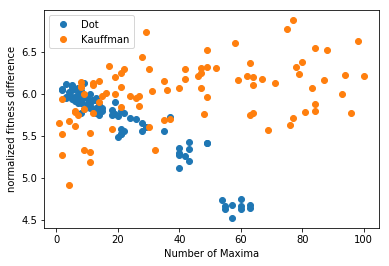

In [87]:
groups = Df_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Number_Maxima"], group["Normalized_MinMax_Fit_Diff"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("normalized fitness difference")
plt.savefig('Max-Min_Fitt_Diff_Dot_Kauffman.png')
plt.show()


# Now Plot distances from local to global maxima

In [89]:
#Read in Data and merge
DFDistances_Kauffman = pd.read_csv('Kauffman_Model_Maxima_Distance_Stats')
DFDistances_Dot = pd.read_csv('Dot_Model_Maxima_Distance_Stats')
Df_Distances_Combined = DFDistances_Dot.append(DFDistances_Kauffman)
Df_Distances_Combined=Df_Distances_Combined[Df_Distances_Combined['Mean_Distance']>=1]#Drop if no other maxima

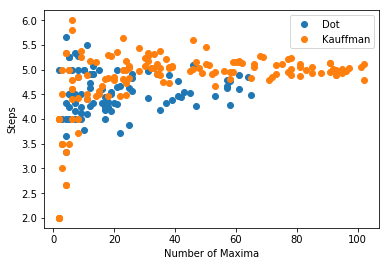

In [90]:
groups = Df_Distances_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Num_Local_Max"], group["Mean_Distance"], marker="o", linestyle="", label=name)
plt.legend()

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Steps")
plt.savefig('Mean_Maxima_Distances_to_Global.png')
plt.show()


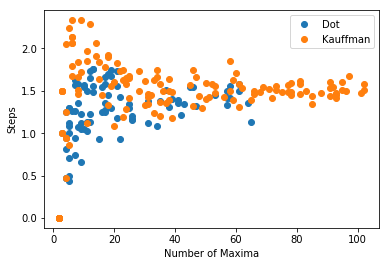

In [49]:

groups = Df_Distances_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Num_Local_Max"], group["Var_Distance"]**.5, marker="o", linestyle="", label=name)
plt.legend(title="Model",)


plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Mean Steps")
plt.savefig('SD_Maxima_Distances_to_Global.png')
plt.show()


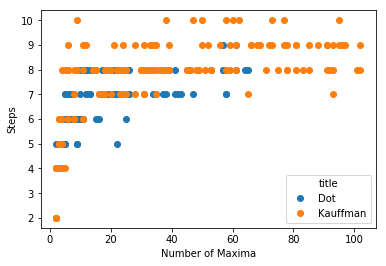

In [91]:
groups = Df_Distances_Combined.groupby("Type")
for name, group in groups:
    plt.plot(group["Num_Local_Max"], group["Max_Distance"], marker="o", linestyle="", label=name)
plt.legend(title="Model",)

plt.title("")
plt.xlabel("Number of Maxima")
plt.ylabel("Standard Deviation of Steps")
plt.savefig('Max_Maxima_Distances_to_Global.png')
plt.show()
